In [1]:
%load_ext autoreload

In [10]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda, LightningWrapper
from gpt.alt_model import ViT as AltViT
from gpt.data import MNISTDataModule, CIFAR10DataModule
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from rich.progress import track

In [3]:
mnist = MNISTDataModule(root_dir='/scratch/gpfs/js5013/data/ml/', num_workers=4, batch_size=8)
mnist.setup()

In [4]:
tl = mnist.test_dataloader()

In [5]:
x, y = next(iter(tl))

In [22]:
model = LightningWrapper.load_from_checkpoint('../train/lightning_logs/version_1023219/checkpoints/epoch=9-step=2350.ckpt')
model.freeze()

/scratch/gpfs/js5013/.conda/envs/foundation/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'output_head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_head'])`.


In [23]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(None, tensor([9, 0, 1, 2, 3, 4, 5, 6]))

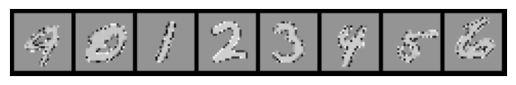

In [24]:
show(torchvision.utils.make_grid(x)), y

In [25]:
torch.argmax(model(x.cuda()), 1)

tensor([9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')

In [26]:
score = 0
total = 0
for x, y in track(tl, total=len(tl)):
    with torch.no_grad():
        out = model(x.cuda())
        pred = torch.argmax(out, 1).cpu()
    score += torch.sum(pred == y)
    total += x.shape[0]

Output()

In [27]:
score / total

tensor(0.9683)